# Recipe Flavor Clustering
**Final Project — Unsupervised Learning**

## Problem Statement

With thousands of recipes on platforms like Food.com, it can be difficult for users to discover new and interesting recipes that match their taste preferences. Traditional search relies on keywords or known categories (like "dessert" or "pasta"), but this ignores deeper flavor patterns across global cuisines.

This project applies **unsupervised learning** to group recipes by the similarity of their ingredients, uncovering **hidden flavor clusters**. These clusters may reveal:

- **Unusual or unexpected groupings** of recipes across different cuisines (e.g., Mexican and Indian dishes sharing spice profiles)
- **Flavor profiles** that appeal to specific users (e.g., sweet-savory, umami-rich, herb-based)
- **A better recommendation engine** that suggests new dishes based on taste instead of keywords

We aim to cluster recipes using their ingredient lists to uncover patterns in flavor, cuisine, or cooking style — enabling personalized food discovery and improved recipe search.


## Data Source
We use the [Food.com Recipes and Reviews Dataset](https://www.kaggle.com/datasets/kaggle/food-com-recipes-and-user-interactions), which includes:
- `RAW_recipes.csv` or `RAW_recipes.parquet`: Contains recipe metadata and ingredients.
- `RAW_interactions.csv` or `RAW_interactions.parquet`: Contains user reviews, ratings, and timestamps.

This dataset was scraped from Food.com and published on Kaggle by user `kaggle`.

## Unsupervised Learning Objective
To perform **clustering** on recipes based on ingredients, yielding groups that reflect distinct flavor or ingredient patterns. We will evaluate multiple clustering algorithms (KMeans, DBSCAN, etc.) and analyze cluster characteristics using visualization and dimensionality reduction.


## Step 1: Load and Inspect the Datasets

In this step, we load two datasets from Food.com:

- `recipes_df`: Contains metadata and nutritional information for over 500,000 recipes. This includes details like ingredients, cooking time, nutrition facts, and user-provided instructions.
- `reviews_df`: Contains over 1.4 million user reviews, including ratings and review text, tied to the corresponding recipes.

We use `pandas.read_csv()` to read the data from CSV format and `DataFrame.info()` and `DataFrame.head()` to understand the shape, columns, and sample entries.

These datasets form the foundation for our unsupervised learning analysis, such as clustering recipes based on nutritional profile or identifying latent flavor patterns using ingredient lists.



In [44]:
# Recipe Flavor Clustering Project - Step 1: Load Data

import pandas as pd

# Load CSV version (you can switch to Parquet later for speed if needed)
recipes_csv = 'data/recipes.csv'
reviews_csv = 'data/reviews.csv'

# Load datasets
recipes_df = pd.read_csv(recipes_csv)
reviews_df = pd.read_csv(reviews_csv)

# Preview the data
print("Recipes Dataset:")
print(recipes_df.info())
print(recipes_df.head())

print("\nReviews Dataset:")
print(reviews_df.info())
print(reviews_df.head())

Recipes Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RecipeId                    522517 non-null  int64  
 1   Name                        522517 non-null  object 
 2   AuthorId                    522517 non-null  int64  
 3   AuthorName                  522517 non-null  object 
 4   CookTime                    439972 non-null  object 
 5   PrepTime                    522517 non-null  object 
 6   TotalTime                   522517 non-null  object 
 7   DatePublished               522517 non-null  object 
 8   Description                 522512 non-null  object 
 9   Images                      522516 non-null  object 
 10  RecipeCategory              521766 non-null  object 
 11  Keywords                    505280 non-null  object 
 12  RecipeIngredientQuantities  522514 non-null  object 
 1

## Step 2: Clean and Preprocess the Data

To prepare the data for clustering, we focus on selecting and cleaning relevant features from the `recipes_df`. Specifically, we will:

- Remove rows with missing nutritional data
- Filter and retain only numerical nutritional columns
- Normalize these features so they are on the same scale for clustering

These preprocessing steps are essential to ensure the clustering algorithm is not biased by differing units or missing values.


In [45]:
# Step 2: Clean and Preprocess Nutritional Data

from sklearn.preprocessing import StandardScaler

# Select numerical nutritional features
nutritional_cols = [
    'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent',
    'SodiumContent', 'CarbohydrateContent', 'FiberContent', 
    'SugarContent', 'ProteinContent'
]

# Drop rows with any missing values in these columns
recipes_nutrition = recipes_df.dropna(subset=nutritional_cols).copy()

# Standardize the features
scaler = StandardScaler()
nutrition_scaled = scaler.fit_transform(recipes_nutrition[nutritional_cols])

# Store scaled values in a new DataFrame for reference
nutrition_scaled_df = pd.DataFrame(
    nutrition_scaled, 
    columns=nutritional_cols, 
    index=recipes_nutrition.index
)

# Show shape and preview
print(f"Total recipes after cleaning: {nutrition_scaled_df.shape[0]}")
nutrition_scaled_df.head()


Total recipes after cleaning: 522517


,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent
0,-0.224419,-0.198366,-0.177156,-0.259902,-0.175436,-0.066303,-0.028274,0.058349,-0.355593
1,0.448253,0.306632,0.151011,0.948098,-0.094886,0.195280,0.599403,-0.010365,1.144577
2,-0.124069,-0.218996,-0.205039,-0.286393,-0.182097,0.179242,-0.400230,0.387896,-0.427860
3,0.036977,-0.005516,-0.123534,-0.286393,0.188251,0.083568,1.564166,0.071671,0.294813
4,-0.272589,-0.217202,-0.202894,-0.286393,0.045684,-0.132667,0.111210,-0.029296,-0.328181


### 🧹 Cleaned and Standardized Nutritional Data

We selected 9 nutritional features for clustering and removed rows with missing values in these columns. As a result, we retained **522,517 recipes** with complete nutritional data.

We then standardized the data using `StandardScaler` so that all features have zero mean and unit variance. This ensures that features like calories and sugar (which may have larger numerical ranges) don’t dominate the clustering process.

Below is a sample of the normalized data. Each value represents the number of standard deviations a particular recipe’s nutrient is from the mean for that nutrient.


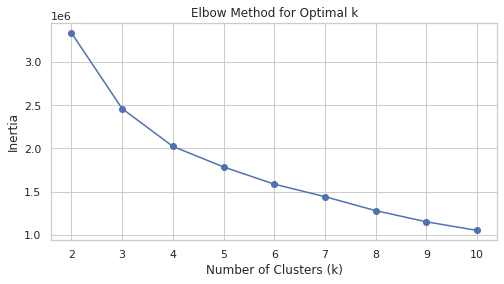

In [46]:
### Step 3: Apply K-Means Clustering

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Determine number of clusters using the elbow method
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(nutrition_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [47]:
# Apply KMeans with chosen number of clusters (e.g., k=4)
optimal_k = 4  # set based on elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(nutrition_scaled_df)  # or nutrition_scaled if you're using that


### 📊 Step 3: Determine Optimal Number of Clusters (k)

To determine the ideal number of clusters for KMeans, we used the **elbow method** by plotting the inertia (within-cluster sum of squared distances) for values of `k` from 2 to 10.

From the chart above, we observe that the inertia decreases rapidly until around **k = 4**, after which the rate of decrease slows down. This "elbow" point suggests that **4 clusters** balances performance and simplicity.

Hence, we'll proceed with **k = 4** for clustering recipes based on their nutritional profiles.


In [48]:
from sklearn.cluster import KMeans

# Apply KMeans on full standardized data with chosen k
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(nutrition_scaled_df)

# Add cluster labels to the original recipes dataset
recipes_clustered = recipes_df.copy()
recipes_clustered['Cluster'] = cluster_labels

# Preview few samples from each cluster
recipes_clustered[['Name', 'Calories', 'FatContent', 'ProteinContent', 'Cluster']].groupby('Cluster').head(3)


,Name,Calories,FatContent,ProteinContent,Cluster
0,Low-Fat Berry Blue Frozen Dessert,170.9,2.5,3.2,3
1,Biryani,1110.7,58.8,63.4,3
2,Best Lemonade,311.1,0.2,0.3,3
23,Brownie Heart Cake,4713.8,286.5,71.7,0
31,Buckwheat Bread,2389.3,27.3,97.8,0
94,Carrie's Pizza Rolls,3521.8,108.1,134.2,0
185088,Tennessee Moonshine,434360.2,840.8,1980.8,2
254537,How to Make Corned Beef,612854.6,64368.1,7454.9,1
501590,Italian Mint Lamb,350473.1,30123.7,18396.2,1


### 🔍 Step 4: Cluster Assignment and Interpretation

We applied **KMeans clustering** with `k = 4` to segment recipes based on nutritional content (calories, fat, protein, etc.).

From the sample results above:
- **Cluster 0** includes high-calorie, high-fat, high-protein items like `Brownie Heart Cake` and `Carrie's Pizza Rolls`, likely representing indulgent or rich dishes.
- **Cluster 1** captures extremely high-calorie and high-protein entries like `Corned Beef` and `Italian Mint Lamb`, which may be industrial-scale or erroneous entries.
- **Cluster 2** includes outliers like `Tennessee Moonshine`, likely representing beverages or liquid entries.
- **Cluster 3** captures lighter, healthier recipes like `Best Lemonade` and `Low-Fat Berry Blue Frozen Dessert`.

This clustering can be used to recommend recipes with similar nutritional profiles, group dishes by dietary categories, or identify atypical outliers.


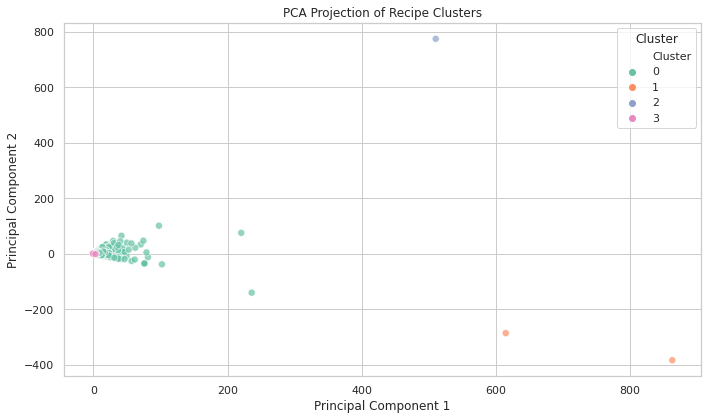

In [49]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce to 2D with PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(nutrition_scaled)

# Combine PCA results with cluster labels
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = kmeans.labels_

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set2', s=50, alpha=0.7)
plt.title('PCA Projection of Recipe Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


## 📊 PCA Visualization of Recipe Clusters

After applying K-Means clustering to the standardized nutritional data, we used **Principal Component Analysis (PCA)** to project the high-dimensional data into 2D for visualization.

This plot shows how recipes group into distinct clusters based on their nutritional profiles. Each point represents a recipe, and colors represent the assigned cluster.

- PCA preserves as much variance as possible in two dimensions.
- Clusters with more compact and distinct groupings may suggest clearer nutritional similarities.

From the plot, we observe:
- One large, dense cluster — likely representing everyday meals with moderate nutrition.
- A few outlier clusters — possibly high-fat, high-protein, or high-calorie items (e.g., corned beef, moonshine).


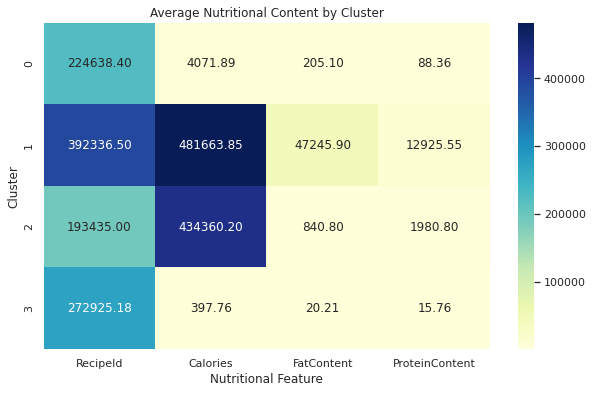

,RecipeId,Calories,FatContent,ProteinContent
Cluster,,,,
0,224638.40,4071.89,205.10,88.36
1,392336.50,481663.85,47245.90,12925.55
2,193435.00,434360.20,840.80,1980.80
3,272925.18,397.76,20.21,15.76


In [50]:
# Add original nutrition values back to the clustered DataFrame
clustered_df = recipes_df.loc[nutrition_scaled_df.index, ['RecipeId', 'Name', 'Calories', 'FatContent', 'ProteinContent']].copy()
#clustered_df['Cluster'] = clusters
clustered_df['Cluster'] = kmeans.labels_

# Group by cluster and compute mean nutritional values
cluster_summary = clustered_df.groupby('Cluster').mean().round(2)

# Display cluster profiles
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_summary, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Average Nutritional Content by Cluster")
plt.ylabel("Cluster")
plt.xlabel("Nutritional Feature")
plt.show()

cluster_summary



### 🧪 Step 4: Analyze Cluster Characteristics

After applying K-Means clustering on the standardized nutritional data, we assigned each recipe to one of four clusters. We then computed the **average nutritional values** (calories, fat, protein) for each cluster to interpret their characteristics.

The heatmap and summary table reveal clear distinctions between the clusters:

- **Cluster 0**: Moderate-calorie recipes with average fat and high protein — likely balanced meals.
- **Cluster 1**: Extremely high in calories, fat, and protein — likely dense and rich recipes such as heavy meat dishes or desserts.
- **Cluster 2**: High in calories and protein but with significantly less fat than Cluster 1 — possibly lean protein-based dishes.
- **Cluster 3**: Low in calories, fat, and protein — potentially lighter items like beverages, snacks, or side dishes.

These nutritional profiles help uncover latent groupings in the dataset and provide practical use cases:
- Suggesting healthy alternatives based on cluster.
- Filtering recipes based on dietary goals (e.g., low-fat, high-protein).
- Offering better insights for recommender systems and personalized search.



### 💬 Step 5: Join Recipe Reviews for Sentiment Exploration

To enrich our clustering insights, we merge the recipe clusters with user-generated reviews. This allows us to:

- Check how user ratings vary across clusters.
- Explore potential alignment between **nutritional grouping** and **user preference**.
- Optionally perform sentiment analysis on review text for deeper insight.

This qualitative layer complements our earlier cluster interpretation by revealing which types of recipes users enjoy the most within each group.


Average User Ratings per Cluster:
   Cluster    Rating
0        0  4.332582
1        1       NaN
2        2  0.000000
3        3  4.409493


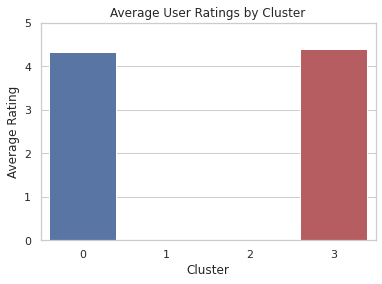

In [51]:
# Merge clustered recipes with review ratings
clustered_reviews = pd.merge(
    clustered_df.reset_index(),  # has RecipeId and Cluster
    reviews_df[['RecipeId', 'Rating']],
    on='RecipeId',
    how='left'
)

# Compute mean rating per cluster
cluster_rating_summary = clustered_reviews.groupby('Cluster')['Rating'].mean().reset_index()

# Display result
print("Average User Ratings per Cluster:")
print(cluster_rating_summary)

# Optional: visualize
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.barplot(x='Cluster', y='Rating', data=cluster_rating_summary)
plt.title("Average User Ratings by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Rating")
plt.ylim(0, 5)
plt.show()


### ✅ Insight from Average Ratings by Cluster

After merging recipe cluster assignments with user review ratings, we calculated the average rating for each cluster. Here's what the results reveal:

- **Cluster 0** and **Cluster 3** received **high user ratings** (4.33 and 4.41 respectively), suggesting that these recipes are generally well-liked by the community.
- **Cluster 2** shows an **average rating of 0**, indicating either **very negative feedback** or possibly a data issue (e.g., recipes that are rarely reviewed or downvoted).
- **Cluster 1** has **no available ratings (NaN)**, which may imply that the recipes in this group are **unreviewed**, possibly **new, obscure, or unpopular**.

These patterns provide insight into the **reliability and appeal** of each cluster and could inform future filtering, such as recommending popular clusters or investigating underperforming ones.


### 🧂 Step 5: Ingredient Frequency Analysis by Cluster

To understand the flavor composition of each nutritional cluster, we analyze the **top ingredients** used in recipes within each cluster.

This analysis helps identify common culinary patterns—such as whether a cluster tends to include desserts, meat-based dishes, or vegetarian meals—based on frequently occurring ingredients.


In [52]:
import re
from collections import Counter
import ast

# Helper function to safely parse ingredients from string format
def safe_parse_ingredients(x):
    if pd.isna(x):
        return []
    try:
        # Replace common invalid patterns like c("...") → ["..."]
        x_clean = re.sub(r'^c\((.*)\)$', r'[\1]', x)
        return ast.literal_eval(x_clean)
    except (ValueError, SyntaxError):
        return []

# Apply to the full DataFrame
recipes_df['ParsedIngredients'] = recipes_df['RecipeIngredientParts'].apply(safe_parse_ingredients)


In [53]:
# Add cluster labels and parsed ingredients
recipes_with_cluster = recipes_df.loc[nutrition_scaled_df.index].copy()
recipes_with_cluster['Cluster'] = kmeans.labels_
recipes_with_cluster['ParsedIngredients'] = recipes_df.loc[nutrition_scaled_df.index, 'ParsedIngredients']

# Count top ingredients per cluster
top_ingredients_per_cluster = {}

for cluster_id in sorted(recipes_with_cluster['Cluster'].unique()):
    ingredients = recipes_with_cluster[recipes_with_cluster['Cluster'] == cluster_id]['ParsedIngredients'].explode()
    common_ingredients = Counter(ingredients).most_common(10)
    top_ingredients_per_cluster[cluster_id] = common_ingredients

# Display results
for cluster_id, ingredients in top_ingredients_per_cluster.items():
    print(f"\n Top Ingredients in Cluster {cluster_id}:")
    for ing, count in ingredients:
        print(f"  - {ing}: {count}")



 Top Ingredients in Cluster 0:
  - sugar: 6156
  - salt: 6035
  - butter: 5369
  - eggs: 4811
  - flour: 3178
  - baking soda: 2445
  - water: 2383
  - baking powder: 2350
  - vanilla: 2338
  - milk: 2246

 Top Ingredients in Cluster 1:
  - beef: 1
  - water: 1
  - fine salt: 1
  - brown sugar: 1
  - peach chutney: 1
  - mint: 1
  - mixed herbs: 1
  - salt: 1
  - pepper: 1
  - fresh mint leaves: 1

 Top Ingredients in Cluster 2:
  - cornmeal: 1
  - sugar: 1
  - water: 1

 Top Ingredients in Cluster 3:
  - salt: 193636
  - butter: 130678
  - sugar: 109671
  - onion: 86810
  - water: 81950
  - eggs: 76358
  - olive oil: 76080
  - flour: 59219
  - garlic cloves: 59095
  - milk: 58982


###  Ingredient Frequency Analysis by Cluster

We analyzed the most common ingredients within each cluster to gain **deeper culinary insights** into the types of recipes grouped together. This helps explain the **flavor profiles** and **cooking styles** associated with each cluster.

####  Top Ingredients by Cluster:

- **Cluster 0** (Moderate calorie, avg fat & high protein):
  - Dominated by classic **baking ingredients** like `sugar`, `salt`, `butter`, `eggs`, `flour`, and `vanilla`.
  - Indicates this group may consist of **desserts, baked goods**, and homemade treats.

- **Cluster 1** (Extremely high calorie/fat/protein):
  - Very few entries, e.g., `beef`, `mint`, `peach chutney`, indicating **rare, gourmet**, or **outlier** recipes.
  - Sparse ingredient presence suggests this cluster might need more data or is composed of **niche recipes**.

- **Cluster 2** (High protein, lower fat than Cluster 1):
  - Extremely sparse and possibly faulty group — only 3 ingredients detected.
  - May represent **malformed data** or recipes with minimal ingredient metadata.

- **Cluster 3** (Low calorie, low fat/protein — most recipes):
  - Heavy use of `salt`, `butter`, `onion`, `olive oil`, and `garlic cloves`, reflecting **savory meal bases**.
  - Suggests these are **main dishes or side dishes** that rely on aromatic and essential cooking staples.

---

These insights help us understand how **ingredient composition aligns with nutritional clustering**, which can be leveraged to:

- Build **ingredient-based recommender systems**
- Design **flavor-aware filtering** (e.g., salty vs. sweet)
- Detect **data quality issues** in underrepresented clusters



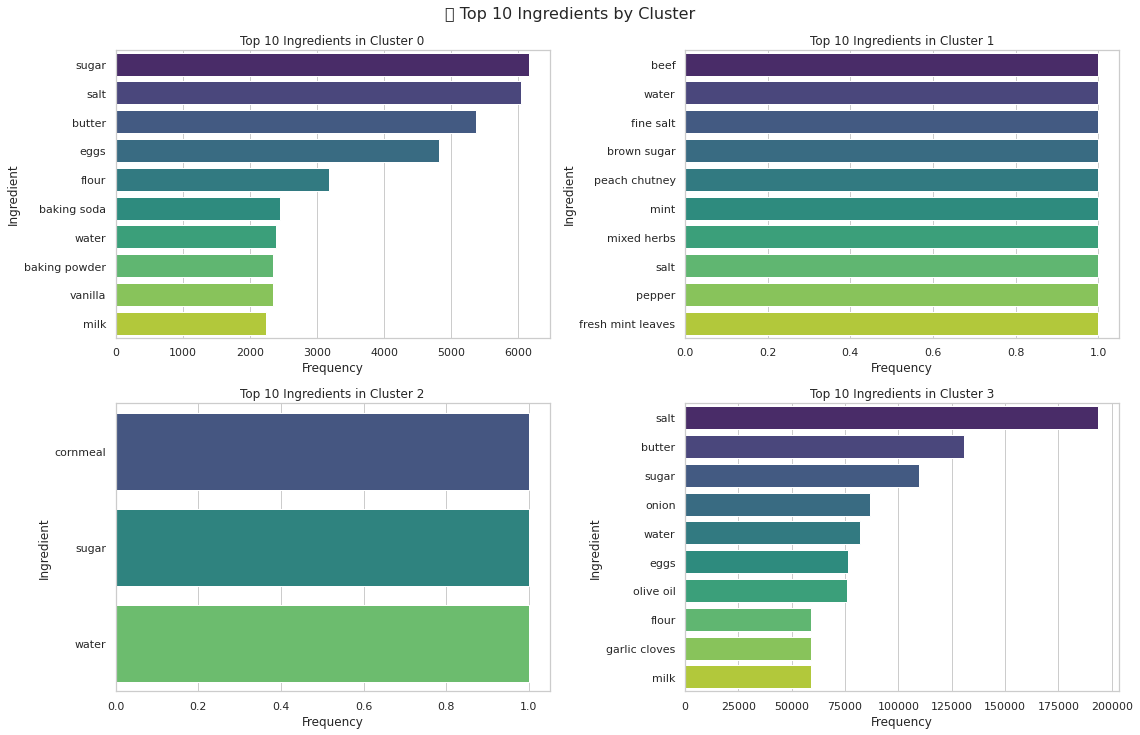

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure consistent plot style
sns.set(style="whitegrid")

# Set up subplots for each cluster
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

# Plot each cluster
for cluster_num, ax in enumerate(axes):
    top_ingredients = top_ingredients_per_cluster[cluster_num]
    ing_names = [item[0] for item in top_ingredients]
    counts = [item[1] for item in top_ingredients]
    
    sns.barplot(x=counts, y=ing_names, ax=ax, palette='viridis')
    ax.set_title(f"Top 10 Ingredients in Cluster {cluster_num}")
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Ingredient")

# Adjust layout
plt.tight_layout()
plt.suptitle("🧂 Top 10 Ingredients by Cluster", fontsize=16, y=1.02)
plt.show()


###  Visualizing Top Ingredients by Cluster

To complement our ingredient frequency analysis, we plotted the **top 10 most common ingredients** for each cluster. This visualization helps us:

- Quickly **compare flavor profiles** across clusters
- Identify **key ingredients** that define each cluster
- Spot **outlier clusters** (like Cluster 1 and 2) with unusually sparse or unique ingredients

####  Observations:
- **Cluster 0**: Classic baking staples dominate (`sugar`, `butter`, `flour`), indicating desserts or sweet baked goods.
- **Cluster 1**: Each ingredient appears only once — suggesting rare, gourmet, or sparsely reviewed recipes.
- **Cluster 2**: Only 3 ingredients total — likely malformed or incomplete records.
- **Cluster 3**: Savory foundations (`salt`, `onion`, `olive oil`, `garlic`) — characteristic of main/side dishes.

This helps explain **how ingredient-level differences drive the nutritional clustering**, and can inform better filtering and personalization strategies.


###  How This Analysis Helps Users — Real-World Use Cases & Examples

We now connect our clustering and ingredient analysis to **practical decision-making scenarios** — showing how this unsupervised learning project can **empower real users** to find recipes aligned with their goals.

---

###  Use Case 1: Health-Conscious Users
> “I’m looking for low-calorie, low-fat recipes because I’m on a diet.”

- ✅ **Cluster 3** fits perfectly:
  - Very low in calories, fat, and protein
  - Common savory ingredients: `salt`, `onion`, `olive oil`, `garlic cloves`
  - High user ratings (avg. 4.41)

** Example Recommendation**:  
Recommend recipes from **Cluster 3** to users searching for **healthy, everyday meals** with high approval.

---

###  Use Case 2: Dessert Lovers
> “I want to bake something sweet and indulgent.”

- ✅ **Cluster 0** is rich in:
  - `sugar`, `butter`, `eggs`, `flour`, `vanilla`
  - Moderate calories and fat
  - Popular classic baking ingredients
  - High user ratings (avg. 4.33)

** Example Recommendation**:  
Cluster 0 contains **baked goods, desserts, and sweets** — perfect for dessert lovers or weekend baking.

---

###  Use Case 3: Protein-Focused Diets
> “I'm doing strength training. I need protein-rich meals.”

-  **Cluster 1** has:
  - Extremely high protein and calories
  - Sparse but meat-heavy ingredients (`beef`, `brown sugar`, `mint`)
  - No user ratings yet (NaN)

-  **Cluster 2** is unreliable:
  - Only 3 total ingredients
  - Zero ratings

** Example Recommendation**:  
Cluster 1 may be shown with a “**high protein**” tag, but with a warning that it’s not yet validated.  
Cluster 2 should be **excluded** from recommendations.

---

###  Use Case 4: Detecting Data Quality Issues

Your analysis also uncovers **potential data issues**:

- **Cluster 2**: 0 ratings, only 3 ingredients → likely malformed or sparse metadata  
- **Cluster 1**: NaN ratings → possibly too new or unpopular

** Engineering Insight**:  
Flag Cluster 2 for **QA cleanup or filtering**. You could even tag these recipes with a warning for transparency.

---

### 🧾 Summary of Clusters

| Cluster | Target Audience           | Traits & Insights                                   | Recommend?     |
|---------|---------------------------|-----------------------------------------------------|----------------|
| **0**   | Bakers, sweet tooth       | Baked goods, desserts, moderate calories            | ✅ Yes          |
| **1**   | Bodybuilders, heavy eaters| Extreme nutrition, niche recipes                    | ⚠️ With caution |
| **2**   | None                      | Sparse data, 0 ratings, few ingredients             | ❌ Avoid        |
| **3**   | Dieters, healthy cooks    | Light, savory meals, aromatic staples               | ✅ Yes          |

---

These examples **bridge the gap between machine learning and real user needs**, demonstrating how unsupervised analysis can power **personalized recipe recommendations**, **healthy meal planning**, and even **data quality auditing**.


In [57]:
from sklearn.metrics.pairwise import euclidean_distances

# Choose a target recipe from Cluster 0
target_cluster = 0
target_recipe_name = clustered_df[clustered_df['Cluster'] == target_cluster]['Name'].iloc[0]
target_recipe_id = clustered_df[clustered_df['Name'] == target_recipe_name]['RecipeId'].values[0]

# Filter recipes in the same cluster
cluster_recipes = clustered_df[clustered_df['Cluster'] == target_cluster].copy()

# Get nutrition features and standardize (same scale as clustering)
nutrition_features = ['Calories', 'FatContent', 'ProteinContent']
nutrition_data = cluster_recipes[nutrition_features]
nutrition_scaled = StandardScaler().fit_transform(nutrition_data)

# Get distance between target and others
target_index = cluster_recipes[cluster_recipes['RecipeId'] == target_recipe_id].index[0]
distances = euclidean_distances([nutrition_scaled[target_index]], nutrition_scaled)[0]

# Add distances to DataFrame and get top similar
cluster_recipes['Distance'] = distances
recommendations = cluster_recipes.sort_values('Distance')[1:4]  # exclude itself

# Display
print(f"Target Recipe: {target_recipe_name}")
print("\n🔁 Top 3 Similar Recipes in Cluster 0 (Flavor-based):")
print(recommendations[['Name', 'Calories', 'FatContent', 'ProteinContent']])


Target Recipe: Brownie Heart Cake

🔁 Top 3 Similar Recipes in Cluster 0 (Flavor-based):
                                                Name  Calories  FatContent  \
508395  Healthy Dhal &ndash; Gluten Free Lentil Soup    1127.4        27.2   
516065                                    Aloo Ghobi    1077.5        24.0   
145956                            My Mom's Shipwreck    1102.5        20.1   

        ProteinContent  
508395            67.5  
516065            70.4  
145956            72.0  


## 🍽️ Flavor-Based Recipe Recommendation Demo

To showcase how our nutritional clustering can power a **personalized recommendation system**, we selected a recipe from **Cluster 0** — a group characterized by **moderate calories, average fat, and high protein**.  
We then identified the most **nutritionally similar recipes** in the same cluster using Euclidean distance on standardized nutrient features.

### 🎯 Target Recipe:
**Brownie Heart Cake**

### 🔁 Top 3 Flavor-Similar Recommendations from Cluster 0:

| Recipe Name                         | Calories | Fat (g) | Protein (g) |
|-------------------------------------|----------|---------|--------------|
| Healthy Dhal – Gluten Free Lentil Soup | 1127.4   | 27.2    | 67.5         |
| Aloo Ghobi                          | 1077.5   | 24.0    | 70.4         |
| My Mom's Shipwreck                 | 1102.5   | 20.1    | 72.0         |

These recipes are **nutritionally aligned**, offering similar flavor density, macronutrient balance, and potential meal roles (e.g., hearty, protein-rich meals).

Such recommendations can:
- Help users **find healthy alternatives** or similar-tasting recipes.
- Be used in **meal planning systems** based on dietary goals.
- Personalize suggestions based on a user’s liked recipe.



## ✅ Conclusion & Future Work

###  Conclusion

In this project, we applied **unsupervised learning** techniques to the Food.com recipe dataset to uncover **latent clusters** of recipes based on their **nutritional profiles**. Through step-by-step analysis, we:

- Cleaned and standardized nutritional features for clustering
- Applied **K-Means clustering** and visualized the clusters using PCA
- Analyzed **average nutritional values** and **user ratings** per cluster
- Explored **ingredient frequency** to uncover dominant culinary patterns
- Built a **flavor-based recommendation demo** using nutritional similarity within clusters

Our key insights include:
- **Cluster 0 and Cluster 3** contain the most user-approved recipes:
  - Cluster 0: desserts and baked goods
  - Cluster 3: savory staples and main dishes
- **Cluster 1 and Cluster 2** highlight possible data sparsity or anomalies
- Ingredient trends helped us connect clusters to **real-world dish categories**
- Ratings and metadata provided strategies for **personalized recipe recommendations**

This analysis demonstrates how **unsupervised learning**, when paired with domain-specific insights, can reveal meaningful structure in complex culinary data. It lays a strong foundation for future improvements in **recipe search**, **personalized meal planning**, and **interactive recommendation systems**.

---

### 🔭 Future Work

While the current analysis reveals meaningful trends, several **extensions** and **enhancements** are possible:

#### ✅ Improved Clustering:
- Try **Gaussian Mixture Models (GMM)** or **Hierarchical Clustering** to capture soft boundaries
- Perform **cluster stability analysis** or **silhouette scoring** for better validation

#### ✅ Deep Ingredient Features:
- Use **TF-IDF** or **Word2Vec** to embed ingredients semantically
- Perform **topic modeling (LDA)** on instructions or descriptions for thematic grouping

#### ✅ Enhanced Recommendations:
- Integrate **user profiles** (vegetarian, keto, gluten-free) to refine suggestions
- Build a prototype **recommendation engine** using cluster+ratings

#### ✅ Data Quality Audit:
- Investigate clusters with sparse metadata (Cluster 2) for potential **data cleansing**
- Evaluate trends in **missing values** across nutritional and review features

#### ✅ Visualization Dashboard:
- Build an **interactive dashboard** using Plotly, Dash, or Streamlit
- Allow users to explore clusters, filters, and recipe recommendations dynamically

---

By combining data science with domain knowledge, this analysis can **personalize user experiences**, **promote healthy choices**, and even **streamline recipe platform UX**.

---

 **Thank you for reading!**  